# GPM: A graph convolutional network based reinforcement learning framework for portfolio management

In this document, we will make use of a graph neural network architecture called GPM, introduced in the following paper:

- Si Shi, Jianjun Li, Guohui Li, Peng Pan, Qi Chen & Qing Sun. (2022). GPM: A graph convolutional network based reinforcement learning framework for portfolio management. https://doi.org/10.1016/j.neucom.2022.04.105.


## Installation and imports

To run this notebook in google colab, uncomment the cells below.

In [3]:
## install finrl library
!pip install swig
!pip install wrds
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

  Obtaining dependency information for swig from https://files.pythonhosted.org/packages/e1/79/316f515d463aa028a51ad116eb826b5215ae4cac75c782bc9e5f5fd63344/swig-4.3.0-py2.py3-none-macosx_10_9_universal2.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 1.3 MB/s eta 0:00:0000:0100:010m

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for wrds from https://files.pythonhosted.org/packages/47/8c/3cce877628950ccb3a0a8d3c77ca6c28d2f5068c20ac3f0c1b44a1db3d7c/wrds-3.2.0-py3-none-any.whl.metadata
  Using cached wrds-3.2.0-py3-none-any.whl.metadata (5.8 kB)
  Obtaining dependency information for numpy<1.27,>=1.26 from https://files.pythonhosted.org/packages/20/f7/b24208eba89f9d1b58c1668bc6c8c4fd472b20c45573cb767f59d49fb0f6/numpy-1.26.4-cp310-cp310-macosx_11_0_arm64.whl.metadata
  Using cached numpy-1.26.4-cp310-cp310-macosx_11_0_arm64.whl.metadata (61 kB)
  Obtaining dependency in

In [4]:
## We also need to install quantstats, because the environment uses it to plot graphs
!pip install quantstats

  Obtaining dependency information for quantstats from https://files.pythonhosted.org/packages/cc/74/b9cf9a2cf911d48c120635b71281a3a28323e97813e7a4d459b6acfd6447/QuantStats-0.0.64-py2.py3-none-any.whl.metadata
  Using cached QuantStats-0.0.64-py2.py3-none-any.whl.metadata (8.9 kB)
  Obtaining dependency information for tabulate>=0.8.0 from https://files.pythonhosted.org/packages/40/44/4a5f08c96eb108af5cb50b41f76142f0afa346dfa99d5296fe7202a11854/tabulate-0.9.0-py3-none-any.whl.metadata
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
Using cached QuantStats-0.0.64-py2.py3-none-any.whl (45 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [7]:
!pip install torch_geometric

  Obtaining dependency information for torch_geometric from https://files.pythonhosted.org/packages/03/9f/157e913626c1acfb3b19ce000b1a6e4e4fb177c0bc0ea0c67ca5bd714b5a/torch_geometric-2.6.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 233.7 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 1.8 MB/s eta 0:00:0000:0100:010m

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [9]:
!pip install gym

  Using cached gym-0.26.2-py3-none-any.whl
  Obtaining dependency information for gym-notices>=0.0.4 from https://files.pythonhosted.org/packages/25/26/d786c6bec30fe6110fd3d22c9a273a2a0e56c0b73b93e25ea1af5a53243b/gym_notices-0.0.8-py3-none-any.whl.metadata
  Using cached gym_notices-0.0.8-py3-none-any.whl.metadata (1.0 kB)
Using cached gym_notices-0.0.8-py3-none-any.whl (3.0 kB)

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
## Hide matplotlib warnings
# import warnings
# warnings.filterwarnings('ignore')

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

#### Import the necessary code libraries

In [2]:
import torch

import numpy as np
import pandas as pd

from torch_geometric.utils import k_hop_subgraph

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import GPM

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Fetch data

We are going to use the same data used in the paper. The original data can be found in [Temporal_Relational_Stock_Ranking repository](https://github.com/fulifeng/Temporal_Relational_Stock_Ranking), but it's not in a FinRL friendly format. So, we're going to get the processed and FinRL-friendly data from [Temporal_Relational_Stock_Ranking_FinRL repository](https://github.com/C4i0kun/Temporal_Relational_Stock_Ranking_FinRL).

In [4]:
# download repository with data and extract tar.gz file with processed temporal data
# !curl -L -O https://github.com/C4i0kun/Temporal_Relational_Stock_Ranking_FinRL/archive/refs/heads/main.zip
# !unzip Temporal_Relational_Stock_Ranking_FinRL-main.zip
!mv Temporal_Relational_Stock_Ranking_FinRL-main Temporal_Relational_Stock_Ranking_FinRL
!tar -xzvf Temporal_Relational_Stock_Ranking_FinRL/temporal_data/temporal_data_processed.tar.gz -C Temporal_Relational_Stock_Ranking_FinRL/temporal_data

x NASDAQ_temporal_data.csv
x NYSE_temporal_data.csv


In [5]:
nasdaq_temporal = pd.read_csv("Temporal_Relational_Stock_Ranking_FinRL/temporal_data/NASDAQ_temporal_data.csv")
nasdaq_temporal

,day,open,high,low,close,volume,tic
0,0,0.270533,0.269522,0.267237,0.263333,0.275333,AABA
1,0,0.238730,0.237522,0.239888,0.240502,0.248031,AAON
2,0,0.424556,0.424768,0.429769,0.442628,0.445018,AAPL
3,0,0.650667,0.648412,0.634492,0.631473,0.667839,AAWW
4,0,0.766565,0.761693,0.759330,0.750061,0.788157,AAXJ
...,...,...,...,...,...,...,...
1277365,1244,0.909992,0.918809,0.912345,0.922698,0.913021,ZBRA
1277366,1244,0.660990,0.648907,0.636086,0.630816,0.665167,ZEUS
1277367,1244,0.981600,0.961674,0.926768,0.914257,0.984345,ZION
1277368,1244,0.980227,0.974903,0.960225,0.964956,0.997580,ZIV


In [6]:
nasdaq_edge_index = np.load("Temporal_Relational_Stock_Ranking_FinRL/relational_data/edge_indexes/NASDAQ_sector_industry_edge_index.npy")
nasdaq_edge_index

array([[   0,   15,    0, ..., 1021, 1014, 1024],
       [  15,    0,   18, ..., 1011, 1024, 1014]])

In [7]:
nasdaq_edge_type = np.load("Temporal_Relational_Stock_Ranking_FinRL/relational_data/edge_types/NASDAQ_sector_industry_edge_type.npy")
nasdaq_edge_type

array([ 0,  0,  0, ...,  1, 26, 26])

### Simplify Data

The graph loaded is too big, causing the training process to be extremely slow. So we are going to remove some of the stocks in the graph structure so that only stocks from 2 hops of the ones in our portfolio are considered.

In [8]:
list_of_stocks = nasdaq_temporal["tic"].unique().tolist()
tics_in_portfolio = ["AAPL", "CMCSA", "CSCO", "FB", "HBAN", "INTC", "MSFT", "MU", "NVDA", "QQQ", "XIV"]

portfolio_nodes = []
for tic in tics_in_portfolio:
    portfolio_nodes.append(list_of_stocks.index(tic))
portfolio_nodes

[2, 185, 215, 310, 395, 464, 596, 603, 637, 768, 1014]

In [9]:
nodes_kept, new_edge_index, nodes_to_select, edge_mask = k_hop_subgraph(
    torch.LongTensor(portfolio_nodes),
    2,
    torch.from_numpy(nasdaq_edge_index),
    relabel_nodes=True,
)

In [10]:
# reduce temporal data
nodes_kept = nodes_kept.tolist()
nasdaq_temporal["tic_id"], _ = pd.factorize(nasdaq_temporal["tic"], sort=True)
nasdaq_temporal = nasdaq_temporal[nasdaq_temporal["tic_id"].isin(nodes_kept)]
nasdaq_temporal = nasdaq_temporal.drop(columns="tic_id")
nasdaq_temporal

,day,open,high,low,close,volume,tic
2,0,0.424556,0.424768,0.429769,0.442628,0.445018,AAPL
4,0,0.766565,0.761693,0.759330,0.750061,0.788157,AAXJ
7,0,0.244700,0.244212,0.238217,0.231041,0.251322,ABCB
8,0,0.689403,0.698864,0.695715,0.675068,0.708124,ABCO
13,0,0.566419,0.564621,0.563147,0.560503,0.579132,ACIW
...,...,...,...,...,...,...,...
1277358,1244,0.923544,0.922537,0.896003,0.888519,0.966042,XIV
1277359,1244,0.919490,0.931946,0.950966,0.960872,0.920000,XLNX
1277361,1244,0.736906,0.747264,0.744030,0.745198,0.743781,YNDX
1277367,1244,0.981600,0.961674,0.926768,0.914257,0.984345,ZION


In [11]:
# reduce edge type
new_edge_type = torch.from_numpy(nasdaq_edge_type)[edge_mask]
_, new_edge_type = torch.unique(new_edge_type, return_inverse=True)
new_edge_type

tensor([0, 0, 0,  ..., 2, 6, 6])

### Instantiate Environment

Using the `PortfolioOptimizationEnv`, it's easy to instantiate a portfolio optimization environment for reinforcement learning agents. In the example below, we use the dataframe created before to start an environment.

In [12]:
df_portfolio = nasdaq_temporal[["day", "tic", "close", "high", "low"]]

df_portfolio_train = df_portfolio[df_portfolio["day"] < 979]
df_portfolio_test = df_portfolio[df_portfolio["day"] >= 979]

In [18]:
len(df_portfolio_train)

407264

In [13]:
environment_train = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=["close", "high", "low"],
        time_column="day",
        normalize_df=None, # dataframe is already normalized
        tics_in_portfolio=tics_in_portfolio
    )

environment_test = PortfolioOptimizationEnv(
        df_portfolio_test,
        initial_amount=100000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=["close", "high", "low"],
        time_column="day",
        normalize_df=None, # dataframe is already normalized
        tics_in_portfolio=tics_in_portfolio
    )

### Instantiate Model

Now, we can instantiate the model using FinRL API. In this example, we are going to use the EI3 architecture introduced by Jiang et. al.

:exclamation: **Note:** Remember to set the architecture's `time_window` parameter with the same value of the environment's `time_window`.

In [14]:
# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": GPM,
}

# here, we can set GPM's parameters
policy_kwargs = {
    "edge_index": new_edge_index,
    "edge_type": new_edge_type,
    "nodes_to_select": nodes_to_select
}

model = DRLAgent(environment_train).get_model("pg", device, model_kwargs, policy_kwargs)

### Train Model

We will train only a few episodes because training takes a considerable time.

看起来训练需要花费很长时间才能走完一个episode

In [16]:
DRLAgent.train_model(model, episodes=2)

  0%|          | 0/2 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 305963.21875
Final accumulative portfolio value: 3.0596321875
Maximum DrawDown: -0.05815055513944978
Sharpe ratio: 11.594083803003027


 50%|█████     | 1/2 [06:47<06:47, 407.67s/it]

Initial portfolio value:100000
Final portfolio value: 788063.375
Final accumulative portfolio value: 7.88063375
Maximum DrawDown: -0.14492677222597972
Sharpe ratio: 8.646679508934293


100%|██████████| 2/2 [13:37<00:00, 408.85s/it]


### Save Model

In [19]:
torch.save(model.train_policy.state_dict(), "policy_GPM.pt")

## Test Model

Following the idea from the original article, we will evaluate the performance of the trained model in the test period. We will also compare with the Uniform buy and hold strategy.

### Test GPM architecture

It's important no note that, in this code, we load the saved policy even though it's not necessary just to show how to save and load your model.

In [21]:
GPM_results = {
    "train": environment_train._asset_memory["final"],
    "test": {},
}

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = GPM(new_edge_index, new_edge_type, nodes_to_select, device=device)
policy.load_state_dict(torch.load("policy_GPM.pt"))

# testing
DRLAgent.DRL_validation(model, environment_test, policy=policy)
GPM_results["test"] = environment_test._asset_memory["final"]

/var/folders/dv/ly5hp_ms3bd9753868lg6c5w0000gn/T/ipykernel_96644/3434580810.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load("policy_GPM

Initial portfolio value:100000
Final portfolio value: 162909.5
Final accumulative portfolio value: 1.629095
Maximum DrawDown: -0.03328069918424792
Sharpe ratio: 8.64522783934371


### Test Uniform Buy and Hold
For comparison, we will also test the performance of a uniform buy and hold strategy. In this strategy, the portfolio has no remaining cash and the same percentage of money is allocated in each asset.

In [22]:
UBAH_results = {
    "train": {},
    "test": {},
}

PORTFOLIO_SIZE = len(tics_in_portfolio)

# train period
terminated = False
environment_train.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_train.step(action)
UBAH_results["train"] = environment_train._asset_memory["final"]

# test period
terminated = False
environment_test.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_test.step(action)
UBAH_results["test"] = environment_test._asset_memory["final"]

Initial portfolio value:100000
Final portfolio value: 210066.515625
Final accumulative portfolio value: 2.10066515625
Maximum DrawDown: -0.1770357694310173
Sharpe ratio: 6.126976338415281
Initial portfolio value:100000
Final portfolio value: 140385.78125
Final accumulative portfolio value: 1.4038578125
Maximum DrawDown: -0.001439125798492591
Sharpe ratio: 23.930156872458472


### Plot graphics

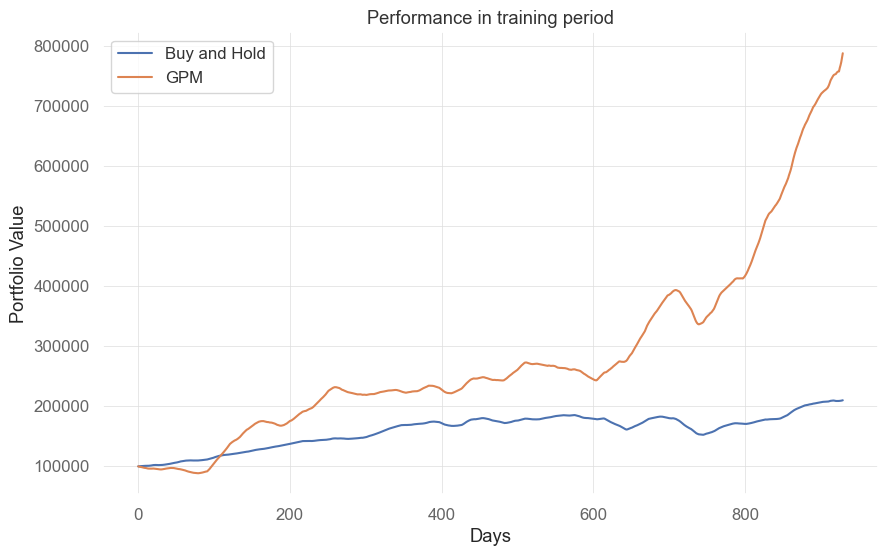

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"], label="Buy and Hold")
plt.plot(GPM_results["train"], label="GPM")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

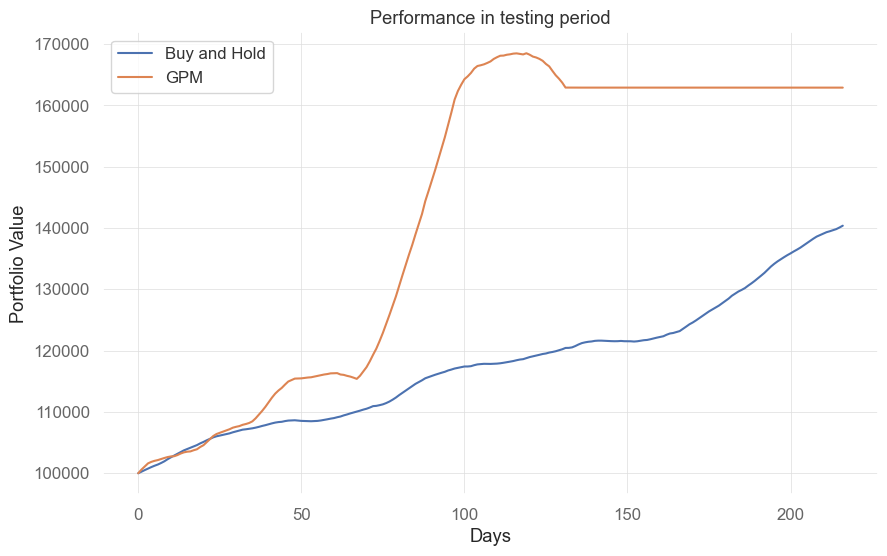

In [24]:
plt.plot(UBAH_results["test"], label="Buy and Hold")
plt.plot(GPM_results["test"], label="GPM")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in testing period")
plt.legend()

plt.show()

With only two training episodes, we can see that GPM achieves better performance than buy and hold strategy, but according to the original article, that performance could be better. Hyperparameter tuning must be performed. Additionaly, we used softmax temperature equal to one, something that can be changed to achieve better performance as stated in the original article.